    1) Slice Time(SPM)
    2) Trimming (nipy)
    3) Motion Correction (FSL)
    4) Brain Extraction (ANTs)
    5) Coregistration (rigid) (ANTs)
    6) Normalization to MNI (non-linear) (ANTs)
    7) Smoothing (FSL)
    8) Downsampling to INT16 precision to save space (nibabel)

In [1]:
from nipype.pipeline.engine import Node, Workflow
from os.path import abspath as abs
from os.path import join as opj
import os

from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12-r7219/spm12_mcr/spm12')

220207-08:48:22,610 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


In [2]:
MNItemplate = abs('./data/templates/MNI152_T1_3mm_brain.nii.gz')
THREADS = 5

In [3]:
preproc = Workflow(name='COBRE_Preprocessing', base_dir=abs('./output/'))

In [4]:
from nipype.algorithms.misc import Gunzip

gunzip_anat = Node(Gunzip(), name='Gunzip_Anatomical')
gunzip_func = Node(Gunzip(), name='Gunzip_Functional')

In [5]:
# Slice Timing

# Slice time correction
# Repetion Time(TR) = 2
# 33 slices per volume
# accusition time = TR - (TR/33)
# choosing the reference slice as the median

from nipype.interfaces.spm import SliceTiming

num_slices = 33
TR = 2
TA = TR - (TR / num_slices)
slice_order = list(range(1, num_slices+1, 2)) + list(range(2, num_slices+1, 2))

slicetime = Node(SliceTiming(num_slices=num_slices,
                             ref_slice=int(num_slices / 2),
                             slice_order=slice_order,
                             time_repetition=TR,
                             time_acquisition=TA),
                 name='Slice_Time_Correction')

In [6]:
# Triming

from nipype.interfaces.nipy.preprocess import Trim

trim = Node(Trim(begin_index=5), name='Magnetic_Saturation_Trim')

In [7]:
# Motion Correction

from nipype.interfaces.fsl import MCFLIRT

realign_fsl = Node(MCFLIRT(cost='mutualinfo', mean_vol=True), name='Motion_Correction')

In [8]:
# Coregisitration after alignment

from nipype.interfaces.fsl.maths import MeanImage

mean_epi = Node(MeanImage(dimension='T'), name='Mean_EPI')

In [9]:
# Brain Extraction

from nipype.interfaces.fsl import BET

bets = Node(BET(), name='Brain_Extraction')

In [10]:
# Coregistration

from nipype.interfaces.ants import Registration

coregistration = Node(Registration(), name='Coregistration')
coregistration.inputs.float = False
coregistration.inputs.output_transform_prefix = 'meanEpi2highres'
coregistration.inputs.transforms = ['Rigid']
coregistration.inputs.transform_parameters = [(0.1,), (0.1,)]
coregistration.inputs.number_of_iterations = [[1000, 500, 250, 100]]
coregistration.inputs.dimension = 3
coregistration.inputs.num_threads = THREADS
coregistration.inputs.write_composite_transform = True
coregistration.inputs.collapse_output_transforms = True
coregistration.inputs.metric = ['MI']
coregistration.inputs.metric_weight = [1]
coregistration.inputs.radius_or_number_of_bins = [32]
coregistration.inputs.sampling_strategy = ['Regular']
coregistration.inputs.sampling_percentage = [0.25]
coregistration.inputs.convergence_threshold = [1e-08]
coregistration.inputs.convergence_window_size = [10]
coregistration.inputs.smoothing_sigmas = [[3, 2, 1, 0]]
coregistration.inputs.sigma_units = ['mm']
coregistration.inputs.shrink_factors = [[4, 3, 2, 1]]
coregistration.inputs.use_estimate_learning_rate_once = [True]
coregistration.inputs.use_histogram_matching = [False]
coregistration.inputs.initial_moving_transform_com = True
coregistration.inputs.output_warped_image = True
coregistration.inputs.winsorize_lower_quantile = 0.01
coregistration.inputs.winsorize_upper_quantile = 0.99

In [11]:
# Normalization

normalization = Node(Registration(), name='Normalization')
normalization.inputs.float = False
normalization.inputs.collapse_output_transforms = True
normalization.inputs.convergence_threshold = [1e-06]
normalization.inputs.convergence_window_size = [10]
normalization.inputs.dimension = 3
normalization.inputs.fixed_image = MNItemplate
normalization.inputs.initial_moving_transform_com = True
normalization.inputs.metric = ['MI', 'MI', 'CC']
normalization.inputs.metric_weight = [1.0]*3
normalization.inputs.number_of_iterations = [[1000, 500, 250, 100],
                                            [1000, 500, 250, 100],
                                            [100, 70, 50, 20]]
normalization.inputs.num_threads = THREADS
normalization.inputs.output_transform_prefix = 'anat2template'
normalization.inputs.output_inverse_warped_image = True
normalization.inputs.output_warped_image = True
normalization.inputs.radius_or_number_of_bins = [32, 32, 4]
normalization.inputs.sampling_percentage = [0.25, 0.25, 1]
normalization.inputs.sampling_strategy = ['Regular', 'Regular', 'None']
normalization.inputs.shrink_factors = [[8, 4, 2, 1]]*3
normalization.inputs.sigma_units = ['vox']*3
normalization.inputs.smoothing_sigmas = [[3, 2, 1, 0]]*3
normalization.inputs.transforms = ['Rigid', 'Affine', 'SyN']
normalization.inputs.transform_parameters = [(0.1,), (0.1,), (0.1, 3.0, 0.0)]
normalization.inputs.use_histogram_matching = True
normalization.inputs.winsorize_lower_quantile = 0.005
normalization.inputs.winsorize_upper_quantile = 0.995
normalization.inputs.write_composite_transform = True

In [12]:
# Apply transformation

from nipype.interfaces.utility import Merge
from nipype.interfaces.ants import Registration, ApplyTransforms

merge_transforms = Node(Merge(2), iterfield=['in2'], name='Merge_Transforms')

apply_transforms = Node(ApplyTransforms(), iterfield=['input_image'], name='Apply_Transforms')
apply_transforms.inputs.input_image_type = 3
apply_transforms.inputs.float = False
apply_transforms.inputs.num_threads = THREADS
apply_transforms.inputs.environ = {}
apply_transforms.inputs.interpolation = 'BSpline'
apply_transforms.inputs.invert_transform_flags = [False, False]
apply_transforms.inputs.reference_image = MNItemplate

In [13]:
# Smoothing

from nipype.interfaces.fsl.utils import Smooth

smooth = Node(Smooth(fwhm=4), name='Smoothing_4mm')

In [14]:
# Downlsampling

from interfaces import Down_Sample_Precision

down_samp = Node(Down_Sample_Precision(), name='Down_Sampling')

In [15]:
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink

experiment_dir = abs('./output')
output_dir = 'datasink'
working_dir = 'workingdir'


# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']), name="infosource")

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('sub-{subject_id}', 'anat', 'sub-{subject_id}_T1w.nii.gz')
func_file = opj('sub-{subject_id}', 'func', 'sub-{subject_id}_task-{task_name}_bold.nii.gz')
templates = {'anat': anat_file,
             'func': func_file}

selectfiles = Node(SelectFiles(templates, base_directory=abs('./data/cobre')), name="Select_Files")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir, container=output_dir), name="Datasink")

## Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-'),
                 ('_task_name_', '-')]

datasink.inputs.substitutions = substitutions

preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')])])

preproc.connect([((selectfiles, gunzip_anat, [('anat', 'in_file')]))])
preproc.connect([((selectfiles, gunzip_func, [('func', 'in_file')]))])

preproc.connect([(down_samp, datasink, [('out_file', 'preproc.@func')])])

In [16]:
preproc.connect([
        (gunzip_func, slicetime, [('out_file', 'in_files')]),
        (slicetime, trim, [('timecorrected_files', 'in_file')]), 
        (trim, realign_fsl, [('out_file', 'in_file')]),
        (realign_fsl, mean_epi, [('out_file', 'in_file')]),
        (gunzip_anat, bets, [('out_file', 'in_file')]),
        (bets, coregistration, [('out_file', 'fixed_image')]),
        (mean_epi, coregistration, [('out_file', 'moving_image')]),
        (bets, normalization, [('out_file', 'moving_image')]),
        (coregistration, merge_transforms, [('composite_transform', 'in2')]),
        (normalization, merge_transforms, [('composite_transform', 'in1')]),
        (merge_transforms, apply_transforms, [('out', 'transforms')]),
        (realign_fsl, apply_transforms, [('out_file', 'input_image')]),
        (smooth, down_samp, [('smoothed_file', 'in_file')]),
        (apply_transforms, smooth, [('output_image', 'in_file')])
    ])

220207-08:48:23,911 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/graph.png (graph2use=colored, simple_form=True).


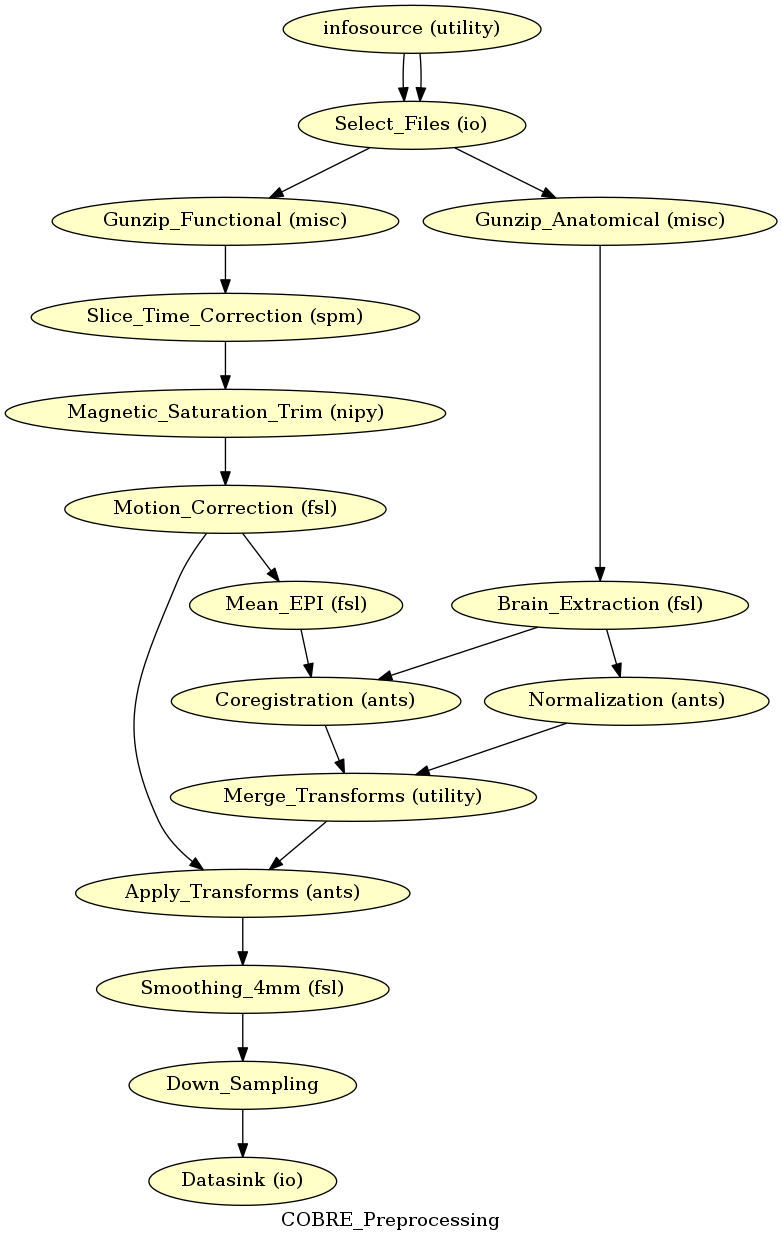

In [17]:
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename='./output/COBRE_Preprocessing/graph.png', width=750)

220207-08:48:24,573 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/graph.png (graph2use=flat, simple_form=True).


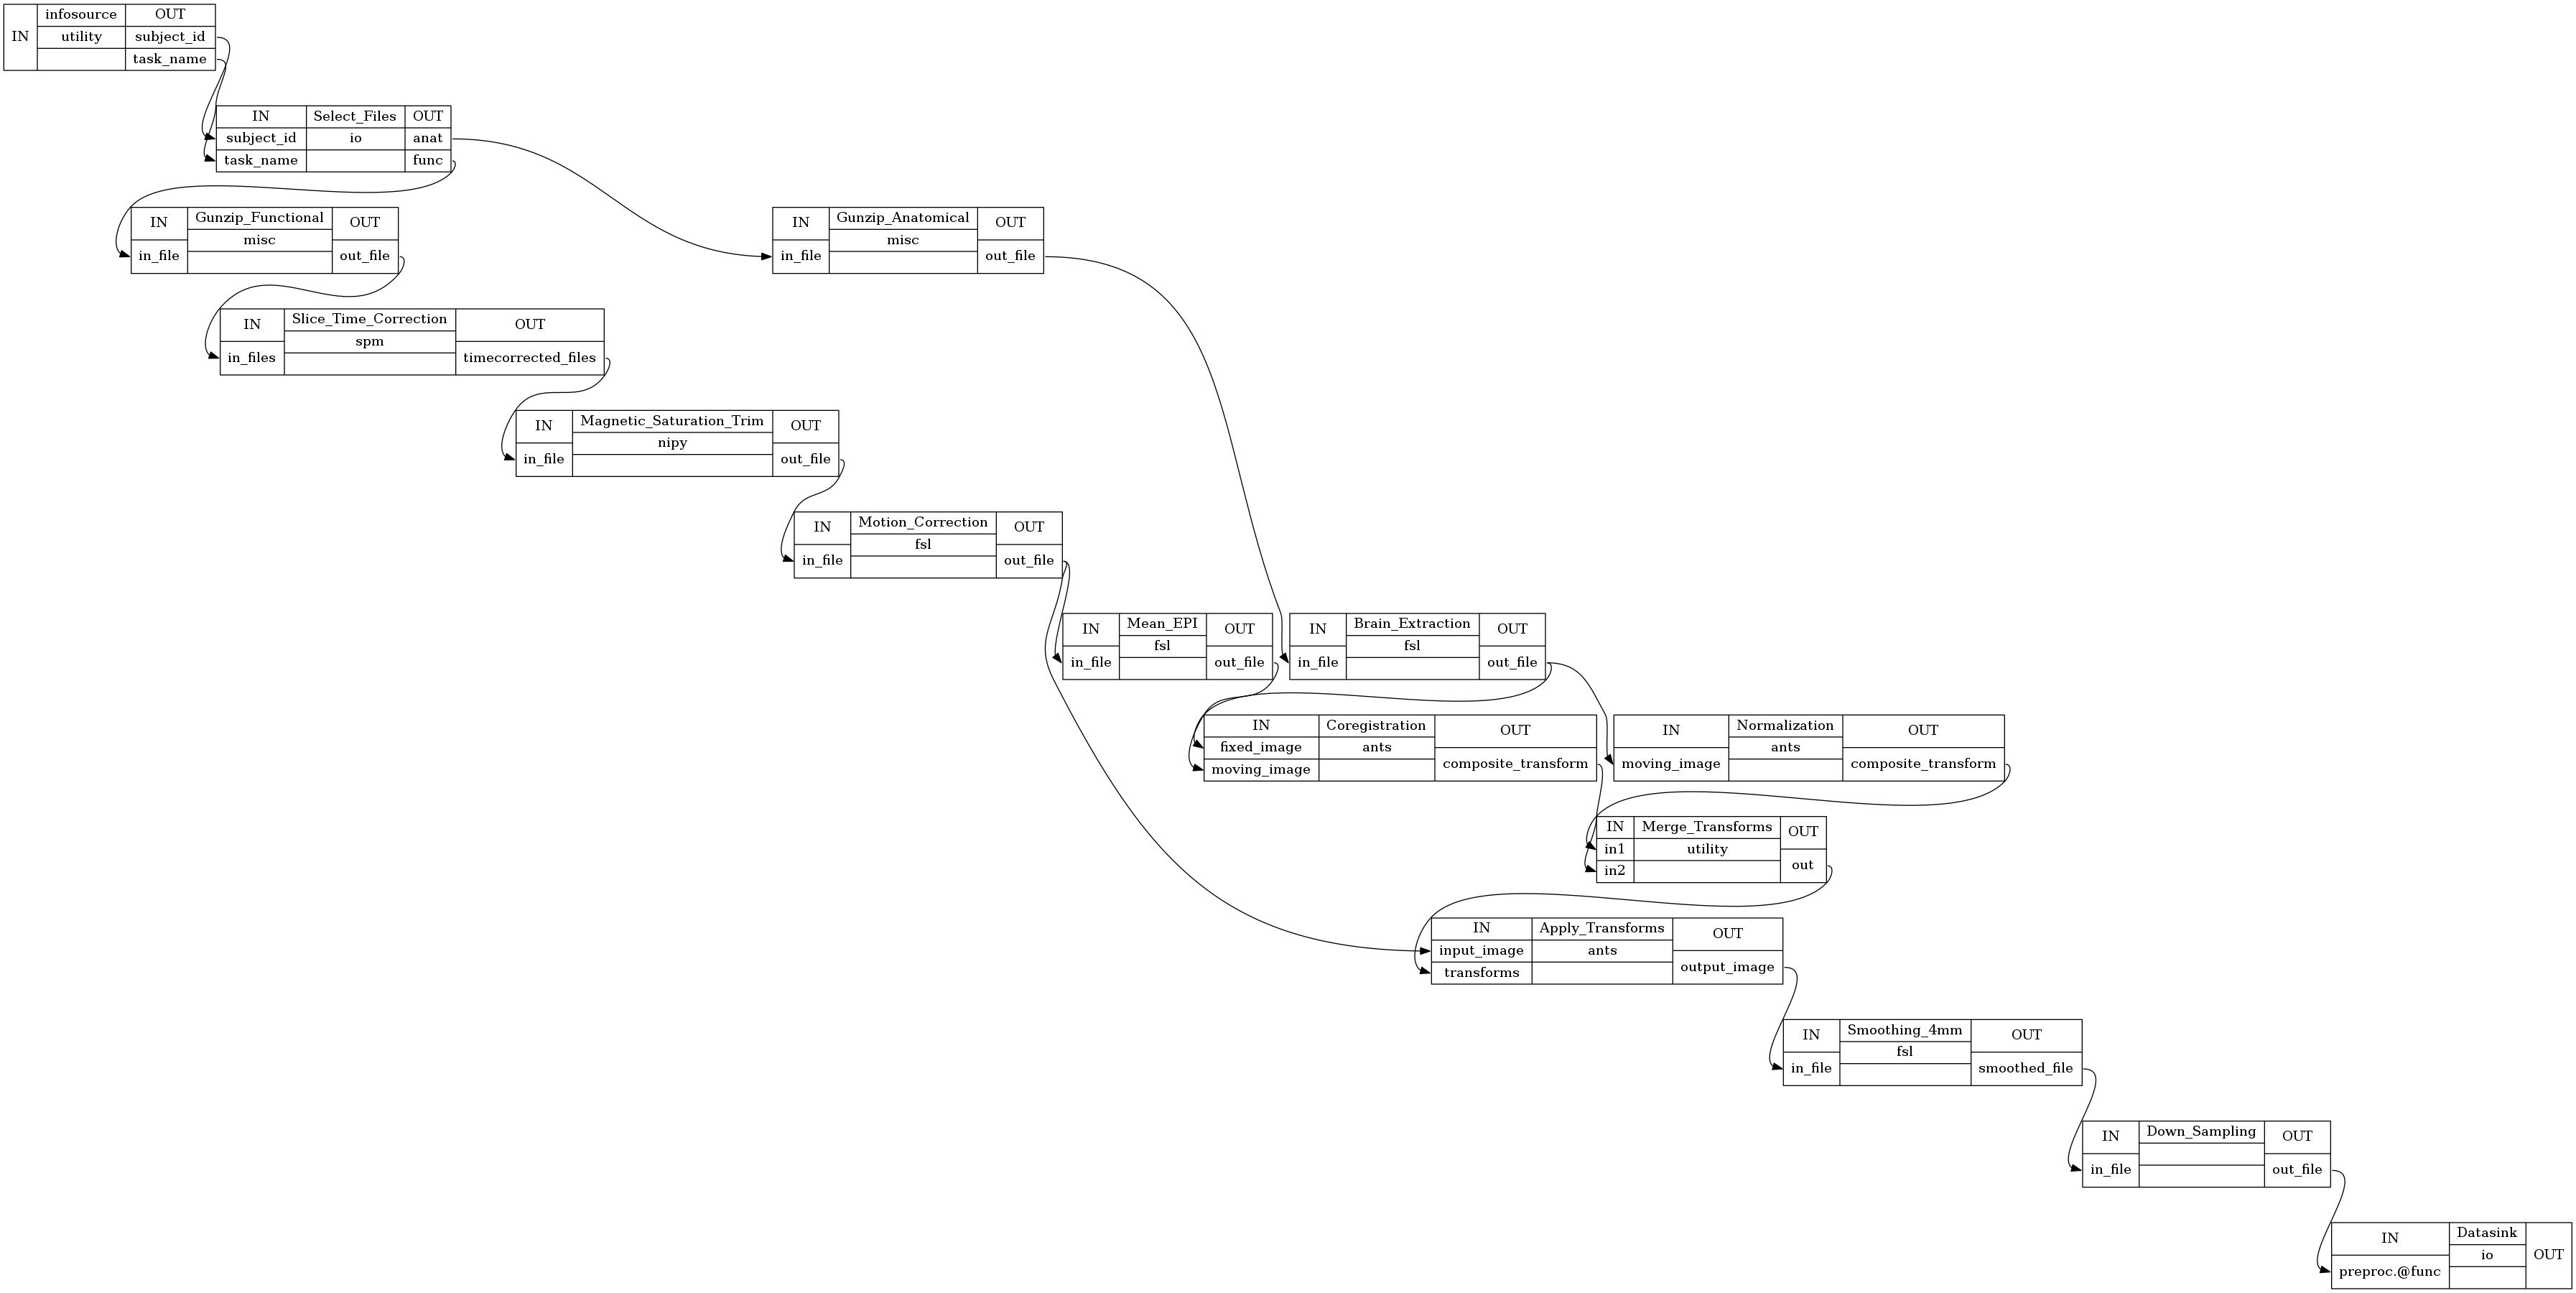

In [18]:
from IPython.display import Image

preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename='/output/COBRE_Preprocessing/graph_detailed.png')

In [19]:
all_subjects = []
for _ in os.listdir('./data/cobre'):
    if _[0:3] == 'sub':
        all_subjects.append(_[4:])

In [20]:
len(all_subjects)

173

In [21]:
# Previous Run = (150, 160)
# Current Run = (160, 173)
# Next Run = (NA, NA)

start, end = 160, 173
subjects = all_subjects[start : end]
subjects

['A00037034',
 'A00037224',
 'A00037238',
 'A00037318',
 'A00037495',
 'A00037564',
 'A00037619',
 'A00037649',
 'A00037665',
 'A00037854',
 'A00038172',
 'A00038441',
 'A00038624']

In [22]:
%%time

for subject in subjects:
    infosource.iterables = [('subject_id', [subject]), ('task_name', ['rest'])]
    preproc.run('MultiProc', plugin_args={'n_procs': 6})
    
    os.system('mkdir ./data/cobre/sub-'+subject+'/preproc')
    os.system('mv ./output/datasink/preproc/sub-'+subject+'-rest/asub-'+subject+'_task-rest_bold_trim_mcf_trans_smooth_int16.nii.gz ./data/cobre/sub-'+subject+'/preproc/sub-'+subject+'_task-rest_bold_MNI_3mm.nii.gz')
    os.system('rm -R ./output/COBRE_Preprocessing/_subject_id_' + subject + '_task_name_rest')
    os.system('rm -R ./output/datasink/preproc/sub-'+subject+'-rest')
    
    print('----------------------------------------------------------------------')
    print('---------------------- Subject' +subject+ 'Completed -------------------------')
    print('----------------------------------------------------------------------')

220207-08:48:24,696 nipype.workflow INFO:
	 Workflow COBRE_Preprocessing settings: ['check', 'execution', 'logging', 'monitoring']
220207-08:48:24,773 nipype.workflow INFO:
	 Running in parallel.
220207-08:48:24,779 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 3.45/3.45, Free processors: 6/6.
220207-08:48:24,897 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Select_Files" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037034_task_name_rest/Select_Files".
220207-08:48:25,16 nipype.workflow INFO:
	 [Node] Running "Select_Files" ("nipype.interfaces.io.SelectFiles")
220207-08:48:25,89 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Select_Files".
220207-08:48:26,780 nipype.workflow INFO:
	 [Job 0] Completed (COBRE_Preprocessing.Select_Files).
220207-08:48:26,785 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 3.45/3.45, Free processors: 6/6.
220207-08

mcflirt -in /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037034_task_name_rest/Magnetic_Saturation_Trim/asub-A00037034_task-rest_bold_trim.nii -cost mutualinfo -meanvol -out /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037034_task_name_rest/Motion_Correction/asub-A00037034_task-rest_bold_trim_mcf.nii.gz
220207-08:49:32,848 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 3.05/3.45, Free processors: 0/6.
                     Currently running:
                       * COBRE_Preprocessing.Motion_Correction
                       * COBRE_Preprocessing.Normalization
220207-08:50:24,751 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Normalization".
220207-08:50:24,900 nipype.workflow INFO:
	 [Job 8] Completed (COBRE_Preprocessing.Normalization).
220207-08:50:24,903 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 3.25/3.45, Free processors: 5/6.
   

	 [Node] Setting-up "COBRE_Preprocessing.Down_Sampling" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037034_task_name_rest/Down_Sampling".
220207-08:55:49,367 nipype.workflow INFO:
	 [Node] Running "Down_Sampling" ("interfaces.Down_Sample_Precision")
220207-08:55:51,243 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 3.25/3.45, Free processors: 5/6.
                     Currently running:
                       * COBRE_Preprocessing.Down_Sampling
220207-08:55:54,733 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Down_Sampling".
220207-08:55:55,247 nipype.workflow INFO:
	 [Job 13] Completed (COBRE_Preprocessing.Down_Sampling).
220207-08:55:55,249 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 3.45/3.45, Free processors: 6/6.
220207-08:55:55,305 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Datasink" in "/home/neuro/nipype_tutorial/output/COBRE_Pr

220207-08:57:03,25 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Slice_Time_Correction".
220207-08:57:03,837 nipype.workflow INFO:
	 [Job 2] Completed (COBRE_Preprocessing.Slice_Time_Correction).
220207-08:57:03,840 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 3.25/3.45, Free processors: 1/6.
                     Currently running:
                       * COBRE_Preprocessing.Normalization
220207-08:57:03,912 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Magnetic_Saturation_Trim" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037224_task_name_rest/Magnetic_Saturation_Trim".
220207-08:57:03,955 nipype.workflow INFO:
	 [Node] Running "Magnetic_Saturation_Trim" ("nipype.interfaces.nipy.preprocess.Trim")
220207-08:57:04,111 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Magnetic_Saturation_Trim".
220207-08:57:05,839 nipype.workflow INFO:
	 [Job 3] Completed (COBRE_Preprocess

220207-09:03:59,178 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Apply_Transforms".
220207-09:04:00,269 nipype.workflow INFO:
	 [Job 11] Completed (COBRE_Preprocessing.Apply_Transforms).
220207-09:04:00,274 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 3.45/3.45, Free processors: 6/6.
220207-09:04:00,334 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Smoothing_4mm" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037224_task_name_rest/Smoothing_4mm".
220207-09:04:00,405 nipype.workflow INFO:
	 [Node] Running "Smoothing_4mm" ("nipype.interfaces.fsl.utils.Smooth"), a CommandLine Interface with command:
fslmaths /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037224_task_name_rest/Apply_Transforms/asub-A00037224_task-rest_bold_trim_mcf_trans.nii.gz -kernel gauss 1.699 -fmean asub-A00037224_task-rest_bold_trim_mcf_trans_smooth.nii.gz
220207-09:04:02,271 nipype.workflow 

antsRegistration --collapse-output-transforms 1 --dimensionality 3 --float 0 --initial-moving-transform [ /home/neuro/nipype_tutorial/data/templates/MNI152_T1_3mm_brain.nii.gz, /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037238_task_name_rest/Brain_Extraction/sub-A00037238_T1w_brain.nii.gz, 1 ] --initialize-transforms-per-stage 0 --interpolation Linear --output [ anat2template, anat2template_Warped.nii.gz, anat2template_InverseWarped.nii.gz ] --transform Rigid[ 0.1 ] --metric MI[ /home/neuro/nipype_tutorial/data/templates/MNI152_T1_3mm_brain.nii.gz, /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037238_task_name_rest/Brain_Extraction/sub-A00037238_T1w_brain.nii.gz, 1, 32, Regular, 0.25 ] --convergence [ 1000x500x250x100, 1e-06, 10 ] --smoothing-sigmas 3.0x2.0x1.0x0.0vox --shrink-factors 8x4x2x1 --use-histogram-matching 1 --transform Affine[ 0.1 ] --metric MI[ /home/neuro/nipype_tutorial/data/templates/MNI152_T1_3mm_brain.nii.gz, /home/ne

220207-09:12:19,317 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Merge_Transforms" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037238_task_name_rest/Merge_Transforms".
220207-09:12:19,396 nipype.workflow INFO:
	 [Node] Running "Merge_Transforms" ("nipype.interfaces.utility.base.Merge")
220207-09:12:19,447 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Merge_Transforms".
220207-09:12:21,253 nipype.workflow INFO:
	 [Job 10] Completed (COBRE_Preprocessing.Merge_Transforms).
220207-09:12:21,257 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 3.45/3.45, Free processors: 6/6.
220207-09:12:21,329 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Apply_Transforms" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037238_task_name_rest/Apply_Transforms".
220207-09:12:21,431 nipype.workflow INFO:
	 [Node] Running "Apply_Transforms" ("nipype.interfaces.ants.r

	 [Node] Setting-up "COBRE_Preprocessing.Brain_Extraction" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037318_task_name_rest/Brain_Extraction".
220207-09:13:37,924 nipype.workflow INFO:
	 [Node] Running "Brain_Extraction" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037318_task_name_rest/Gunzip_Anatomical/sub-A00037318_T1w.nii /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037318_task_name_rest/Brain_Extraction/sub-A00037318_T1w_brain.nii.gz
220207-09:13:37,932 nipype.workflow INFO:
	 [Node] Running "Slice_Time_Correction" ("nipype.interfaces.spm.preprocess.SliceTiming")
220207-09:13:39,787 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 3.05/3.45, Free processors: 4/6.
                     Currently running:
                       * COBRE_Preprocessing.Brain_Extraction
                

	 [Node] Setting-up "COBRE_Preprocessing.Coregistration" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037318_task_name_rest/Coregistration".
220207-09:16:24,128 nipype.workflow INFO:
	 [Node] Running "Coregistration" ("nipype.interfaces.ants.registration.Registration"), a CommandLine Interface with command:
antsRegistration --collapse-output-transforms 1 --dimensionality 3 --float 0 --initial-moving-transform [ /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037318_task_name_rest/Brain_Extraction/sub-A00037318_T1w_brain.nii.gz, /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037318_task_name_rest/Mean_EPI/asub-A00037318_task-rest_bold_trim_mcf_mean.nii.gz, 1 ] --initialize-transforms-per-stage 0 --interpolation Linear --output [ meanEpi2highres, meanEpi2highres_Warped.nii.gz ] --transform Rigid[ 0.1 ] --metric MI[ /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037318_task_name_rest/Brain_Ext

	 [Node] Setting-up "COBRE_Preprocessing.Select_Files" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037495_task_name_rest/Select_Files".
220207-09:23:13,63 nipype.workflow INFO:
	 [Node] Running "Select_Files" ("nipype.interfaces.io.SelectFiles")
220207-09:23:13,126 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Select_Files".
220207-09:23:14,849 nipype.workflow INFO:
	 [Job 0] Completed (COBRE_Preprocessing.Select_Files).
220207-09:23:14,854 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 3.45/3.45, Free processors: 6/6.
220207-09:23:14,920 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Gunzip_Anatomical" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037495_task_name_rest/Gunzip_Anatomical".
220207-09:23:14,918 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Gunzip_Functional" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_

220207-09:25:18,24 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Normalization".
220207-09:25:18,971 nipype.workflow INFO:
	 [Job 8] Completed (COBRE_Preprocessing.Normalization).
220207-09:25:18,973 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 3.25/3.45, Free processors: 5/6.
                     Currently running:
                       * COBRE_Preprocessing.Motion_Correction
220207-09:25:59,681 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Motion_Correction".
220207-09:26:01,16 nipype.workflow INFO:
	 [Job 4] Completed (COBRE_Preprocessing.Motion_Correction).
220207-09:26:01,21 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 3.45/3.45, Free processors: 6/6.
220207-09:26:01,84 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Mean_EPI" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037495_task_name_rest/Mean_EPI".
220207-09:26:01,1

220207-09:30:49,312 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 3.45/3.45, Free processors: 6/6.
220207-09:30:49,374 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Datasink" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037495_task_name_rest/Datasink".
220207-09:30:49,429 nipype.workflow INFO:
	 [Node] Running "Datasink" ("nipype.interfaces.io.DataSink")
220207-09:30:49,434 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/output/datasink/preproc/_subject_id_A00037495_task_name_rest/asub-A00037495_task-rest_bold_trim_mcf_trans_smooth_int16.nii.gz -> /home/neuro/nipype_tutorial/output/datasink/preproc/sub-A00037495-rest/asub-A00037495_task-rest_bold_trim_mcf_trans_smooth_int16.nii.gz
220207-09:30:49,497 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Datasink".
220207-09:30:51,310 nipype.workflow INFO:
	 [Job 14] Completed (COBRE_Preprocessing.Datasink).
220207-09:30:51,314 nipy

220207-09:31:57,891 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Magnetic_Saturation_Trim" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037564_task_name_rest/Magnetic_Saturation_Trim".
220207-09:31:57,950 nipype.workflow INFO:
	 [Node] Running "Magnetic_Saturation_Trim" ("nipype.interfaces.nipy.preprocess.Trim")
220207-09:31:58,96 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Magnetic_Saturation_Trim".
220207-09:31:59,820 nipype.workflow INFO:
	 [Job 3] Completed (COBRE_Preprocessing.Magnetic_Saturation_Trim).
220207-09:31:59,823 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 3.25/3.45, Free processors: 1/6.
                     Currently running:
                       * COBRE_Preprocessing.Normalization
220207-09:31:59,883 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Motion_Correction" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A0003756

	 [Node] Setting-up "COBRE_Preprocessing.Smoothing_4mm" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037564_task_name_rest/Smoothing_4mm".
220207-09:38:00,324 nipype.workflow INFO:
	 [Node] Running "Smoothing_4mm" ("nipype.interfaces.fsl.utils.Smooth"), a CommandLine Interface with command:
fslmaths /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037564_task_name_rest/Apply_Transforms/asub-A00037564_task-rest_bold_trim_mcf_trans.nii.gz -kernel gauss 1.699 -fmean asub-A00037564_task-rest_bold_trim_mcf_trans_smooth.nii.gz
220207-09:38:02,196 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 3.25/3.45, Free processors: 5/6.
                     Currently running:
                       * COBRE_Preprocessing.Smoothing_4mm
220207-09:38:38,759 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Smoothing_4mm".
220207-09:38:40,237 nipype.workflow INFO:
	 [Job 12] Completed (COBRE_Preprocessing.S

antsRegistration --collapse-output-transforms 1 --dimensionality 3 --float 0 --initial-moving-transform [ /home/neuro/nipype_tutorial/data/templates/MNI152_T1_3mm_brain.nii.gz, /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037619_task_name_rest/Brain_Extraction/sub-A00037619_T1w_brain.nii.gz, 1 ] --initialize-transforms-per-stage 0 --interpolation Linear --output [ anat2template, anat2template_Warped.nii.gz, anat2template_InverseWarped.nii.gz ] --transform Rigid[ 0.1 ] --metric MI[ /home/neuro/nipype_tutorial/data/templates/MNI152_T1_3mm_brain.nii.gz, /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037619_task_name_rest/Brain_Extraction/sub-A00037619_T1w_brain.nii.gz, 1, 32, Regular, 0.25 ] --convergence [ 1000x500x250x100, 1e-06, 10 ] --smoothing-sigmas 3.0x2.0x1.0x0.0vox --shrink-factors 8x4x2x1 --use-histogram-matching 1 --transform Affine[ 0.1 ] --metric MI[ /home/neuro/nipype_tutorial/data/templates/MNI152_T1_3mm_brain.nii.gz, /home/ne

220207-09:45:09,176 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Merge_Transforms" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037619_task_name_rest/Merge_Transforms".
220207-09:45:09,248 nipype.workflow INFO:
	 [Node] Running "Merge_Transforms" ("nipype.interfaces.utility.base.Merge")
220207-09:45:09,288 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Merge_Transforms".
220207-09:45:11,114 nipype.workflow INFO:
	 [Job 10] Completed (COBRE_Preprocessing.Merge_Transforms).
220207-09:45:11,120 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 3.45/3.45, Free processors: 6/6.
220207-09:45:11,183 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Apply_Transforms" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037619_task_name_rest/Apply_Transforms".
220207-09:45:11,279 nipype.workflow INFO:
	 [Node] Running "Apply_Transforms" ("nipype.interfaces.ants.r

	 [Node] Setting-up "COBRE_Preprocessing.Brain_Extraction" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037649_task_name_rest/Brain_Extraction".

220207-09:46:33,750 nipype.workflow INFO:
	 [Node] Running "Brain_Extraction" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037649_task_name_rest/Gunzip_Anatomical/sub-A00037649_T1w.nii /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037649_task_name_rest/Brain_Extraction/sub-A00037649_T1w_brain.nii.gz
220207-09:46:33,755 nipype.workflow INFO:
	 [Node] Running "Slice_Time_Correction" ("nipype.interfaces.spm.preprocess.SliceTiming")
220207-09:46:35,621 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 3.05/3.45, Free processors: 4/6.
                     Currently running:
                       * COBRE_Preprocessing.Brain_Extraction
               

	 [Node] Setting-up "COBRE_Preprocessing.Coregistration" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037649_task_name_rest/Coregistration".
220207-09:49:17,936 nipype.workflow INFO:
	 [Node] Running "Coregistration" ("nipype.interfaces.ants.registration.Registration"), a CommandLine Interface with command:
antsRegistration --collapse-output-transforms 1 --dimensionality 3 --float 0 --initial-moving-transform [ /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037649_task_name_rest/Brain_Extraction/sub-A00037649_T1w_brain.nii.gz, /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037649_task_name_rest/Mean_EPI/asub-A00037649_task-rest_bold_trim_mcf_mean.nii.gz, 1 ] --initialize-transforms-per-stage 0 --interpolation Linear --output [ meanEpi2highres, meanEpi2highres_Warped.nii.gz ] --transform Rigid[ 0.1 ] --metric MI[ /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037649_task_name_rest/Brain_Ext

	 [Node] Setting-up "COBRE_Preprocessing.Select_Files" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037665_task_name_rest/Select_Files".
220207-09:53:58,697 nipype.workflow INFO:
	 [Node] Running "Select_Files" ("nipype.interfaces.io.SelectFiles")
220207-09:53:58,749 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Select_Files".
220207-09:54:00,497 nipype.workflow INFO:
	 [Job 0] Completed (COBRE_Preprocessing.Select_Files).
220207-09:54:00,502 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 3.45/3.45, Free processors: 6/6.
220207-09:54:00,557 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Gunzip_Functional" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037665_task_name_rest/Gunzip_Functional".
220207-09:54:00,559 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Gunzip_Anatomical" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject

220207-09:56:00,280 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Normalization".
220207-09:56:00,620 nipype.workflow INFO:
	 [Job 8] Completed (COBRE_Preprocessing.Normalization).
220207-09:56:00,622 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 3.25/3.45, Free processors: 5/6.
                     Currently running:
                       * COBRE_Preprocessing.Motion_Correction
220207-09:56:43,427 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Motion_Correction".
220207-09:56:44,668 nipype.workflow INFO:
	 [Job 4] Completed (COBRE_Preprocessing.Motion_Correction).
220207-09:56:44,672 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 3.45/3.45, Free processors: 6/6.
220207-09:56:44,728 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Mean_EPI" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037665_task_name_rest/Mean_EPI".
220207-09:56:

220207-10:01:32,980 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 3.45/3.45, Free processors: 6/6.
220207-10:01:33,35 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Datasink" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037665_task_name_rest/Datasink".
220207-10:01:33,78 nipype.workflow INFO:
	 [Node] Running "Datasink" ("nipype.interfaces.io.DataSink")
220207-10:01:33,83 nipype.interface INFO:
	 sub: /home/neuro/nipype_tutorial/output/datasink/preproc/_subject_id_A00037665_task_name_rest/asub-A00037665_task-rest_bold_trim_mcf_trans_smooth_int16.nii.gz -> /home/neuro/nipype_tutorial/output/datasink/preproc/sub-A00037665-rest/asub-A00037665_task-rest_bold_trim_mcf_trans_smooth_int16.nii.gz
220207-10:01:33,139 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Datasink".
220207-10:01:34,977 nipype.workflow INFO:
	 [Job 14] Completed (COBRE_Preprocessing.Datasink).
220207-10:01:34,979 nipype.

220207-10:02:41,577 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Magnetic_Saturation_Trim" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037854_task_name_rest/Magnetic_Saturation_Trim".
220207-10:02:41,633 nipype.workflow INFO:
	 [Node] Running "Magnetic_Saturation_Trim" ("nipype.interfaces.nipy.preprocess.Trim")
220207-10:02:41,787 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Magnetic_Saturation_Trim".
220207-10:02:43,503 nipype.workflow INFO:
	 [Job 3] Completed (COBRE_Preprocessing.Magnetic_Saturation_Trim).
220207-10:02:43,506 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 3.25/3.45, Free processors: 1/6.
                     Currently running:
                       * COBRE_Preprocessing.Normalization
220207-10:02:43,571 nipype.workflow INFO:
	 [Node] Setting-up "COBRE_Preprocessing.Motion_Correction" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A000378

	 [Node] Setting-up "COBRE_Preprocessing.Smoothing_4mm" in "/home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037854_task_name_rest/Smoothing_4mm".
220207-10:10:12,72 nipype.workflow INFO:
	 [Node] Running "Smoothing_4mm" ("nipype.interfaces.fsl.utils.Smooth"), a CommandLine Interface with command:
fslmaths /home/neuro/nipype_tutorial/output/COBRE_Preprocessing/_subject_id_A00037854_task_name_rest/Apply_Transforms/asub-A00037854_task-rest_bold_trim_mcf_trans.nii.gz -kernel gauss 1.699 -fmean asub-A00037854_task-rest_bold_trim_mcf_trans_smooth.nii.gz
220207-10:10:13,956 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 3.25/3.45, Free processors: 5/6.
                     Currently running:
                       * COBRE_Preprocessing.Smoothing_4mm
220207-10:10:49,924 nipype.workflow INFO:
	 [Node] Finished "COBRE_Preprocessing.Smoothing_4mm".
220207-10:10:49,995 nipype.workflow INFO:
	 [Job 12] Completed (COBRE_Preprocessing.Sm